<a href="https://colab.research.google.com/github/maorsharon1999/ML/blob/main/Final_project_ML_Maor%26Ido_super_best_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0))


CUDA available: True
Device name: Tesla T4


# Project: Colorectal Histology Classification

In this notebook we will:

1.  Perform Exploratory Data Analysis (EDA) on the raw image patches.  
2.  Build three feature‐extraction pipelines and compare them.  
3.  Run nine baseline classification experiments (SVM, Softmax, NN) on each pipeline.  
4.  Improve the best pipeline via fine‐tuning and hyperparameter tuning.

_All code is deterministic (seeded) and fully reproducible._


## A. Exploratory Data Analysis (EDA)

In this section, we will:

1.  Load and split the dataset (stratified).
2.  Visualize the class distribution in the training set.
3.  Display **3 random samples** per class.
4.  Run **PCA→t-SNE** on the training data and interpret the plot.


In [ ]:
# 1. Imports & global configuration
import os, random, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Set seed for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 2. Load the colorectal histology dataset
import tensorflow_datasets as tfds
X, Y = tfds.as_numpy(tfds.load(
    'colorectal_histology', split='train', batch_size=-1, as_supervised=True
))

# 3. Stratified train-test split and save indices
train_idx, test_idx = train_test_split(
    np.arange(len(Y)), test_size=0.2, stratify=Y, random_state=SEED
)
os.makedirs('data/split', exist_ok=True)
np.save('data/split/train_idx.npy', train_idx)
np.save('data/split/test_idx.npy', test_idx)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/incomplete.HBRPOI_2.0.0/colorectal_histology-train.tf…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


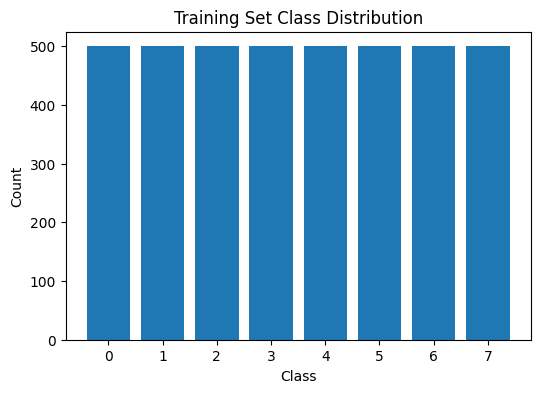

In [ ]:
# 4. Plot class distribution in training set
train_labels = Y[train_idx]
counts = np.bincount(train_labels)
classes = np.arange(len(counts))

plt.figure(figsize=(6,4))
plt.bar(classes, counts)
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(classes)
plt.show()


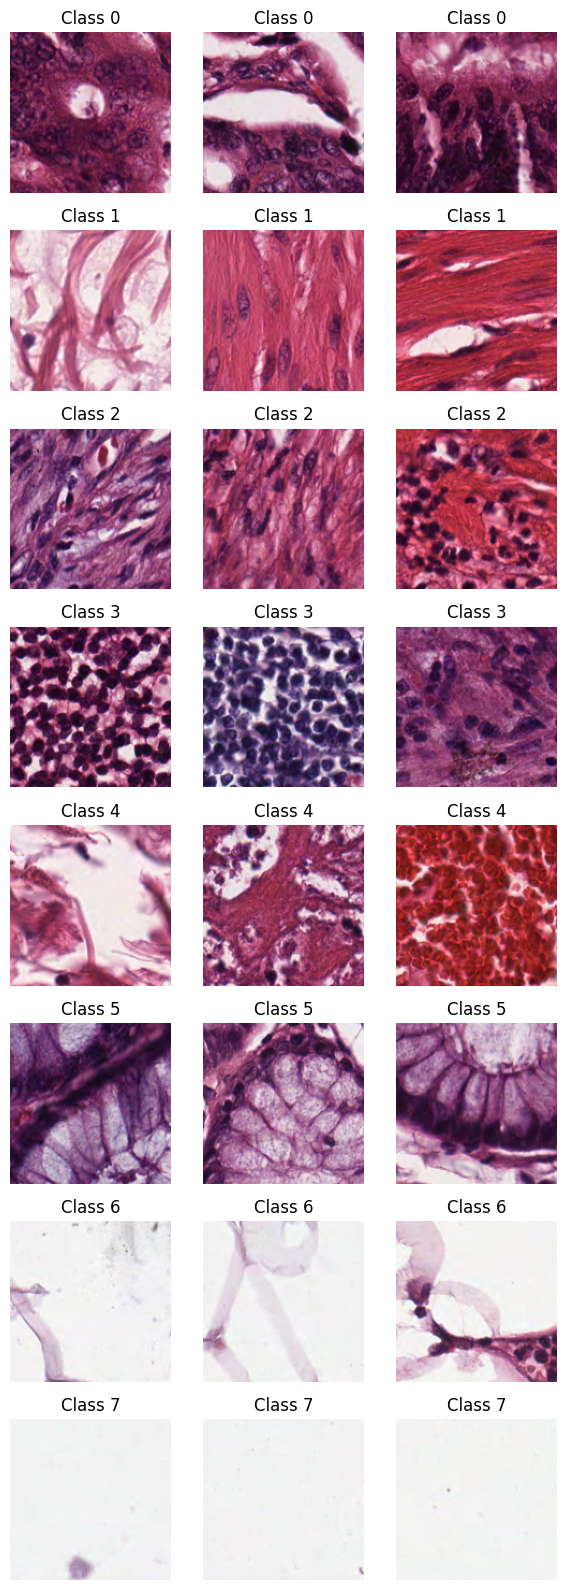

In [ ]:
# 5. Display 3 random samples per class
def plot_samples_per_class(X, Y, idx, samples=3):
    """Show `samples` images for each class in `idx`."""
    cls = np.unique(Y)
    plt.figure(figsize=(samples*2, len(cls)*2))
    for i,c in enumerate(cls):
        cidx = idx[Y[idx] == c]
        sel = np.random.choice(cidx, samples, replace=False)
        for j, img_i in enumerate(sel):
            plt.subplot(len(cls), samples, i*samples + j + 1)
            plt.imshow(X[img_i])
            plt.title(f'Class {c}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples_per_class(X, Y, train_idx)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 46.0 MB/s eta 0:00:00


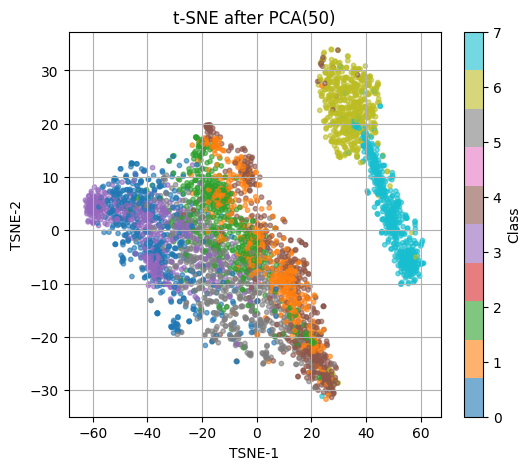

In [ ]:
# 6. PCA → t-SNE visualization
!pip install --quiet openTSNE scikit-learn

# Flatten images
flat = X[train_idx].reshape(len(train_idx), -1)

# PCA to 50 dims
pca = PCA(n_components=50, random_state=SEED)
pca_feats = pca.fit_transform(flat)

# t-SNE to 2 dims
from openTSNE import TSNE
tsne = TSNE(n_components=2, random_state=SEED, n_jobs=-1)
tsne_res = tsne.fit(pca_feats)

# Scatter plot
plt.figure(figsize=(6,5))
plt.scatter(tsne_res[:,0], tsne_res[:,1],
            c=train_labels, cmap='tab10', s=10, alpha=0.6)
plt.title('t-SNE after PCA(50)')
plt.xlabel('TSNE-1'); plt.ylabel('TSNE-2')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()


**Legend:**  
- Color corresponds to class labels 0–7.  
- Tissue types mapping:  
  - **0:** Tumor epithelium  
  - **1:** Simple stroma  
  - **2:** Complex stroma  
  - **3:** Lymphocytes (Immune)  
  - **4:** Debris  
  - **5:** Adipose tissue  
  - **6:** Mucosal glands (Normal)  
  - **7:** Background


### Insights from PCA to t-SNE

- **Clusters of easy classes:** Classes 6 (Normal glands) and 7 (Background) form distinct groups.
- **Overlap of complex classes:** Tumor-related classes overlap heavily, indicating raw pixels are insufficient.
- This motivates **feature extraction** in the next section.


## B. Feature Extraction Pipelines

We define three pipelines:

1. **Downsample & Flatten** → 32×32→3072-D  
2. **Raw Flatten + PCA(256)** → 256-D  
3. **VGG16 Backbone** (no top) → global avg-pool → ~8192-D  

For each, we will:
- Compute feature-wise mean & SD, plot histograms.
- Standardize via `StandardScaler`.
- Run t-SNE(2) on 2500 samples.


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Pipeline: Downsample


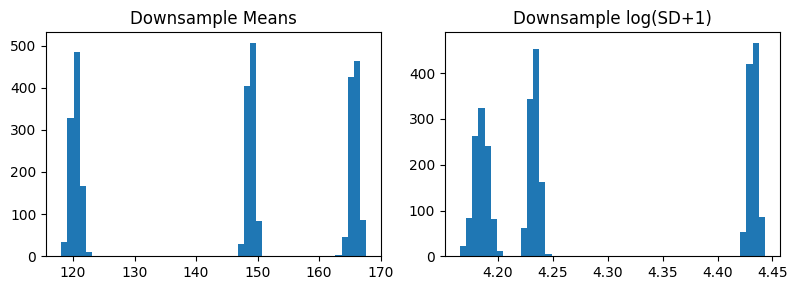

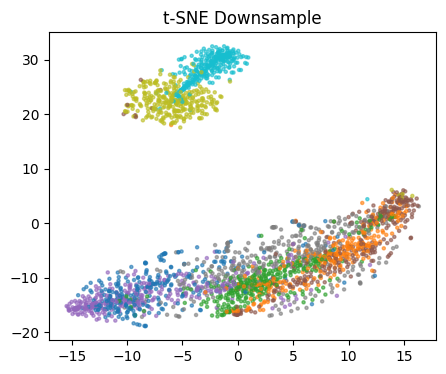


Pipeline: Raw+PCA


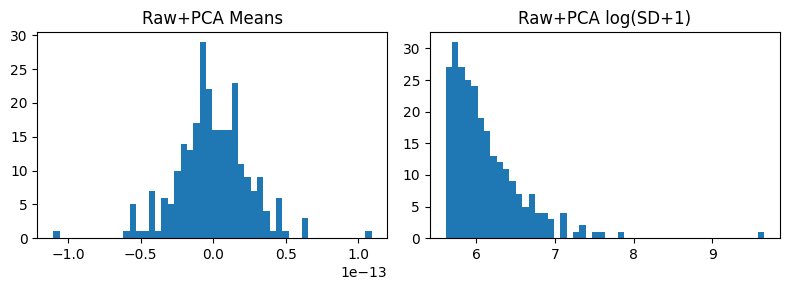

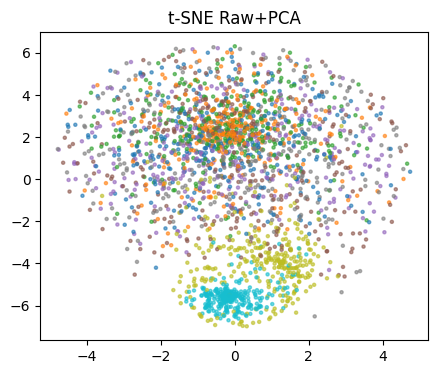


Pipeline: VGG16


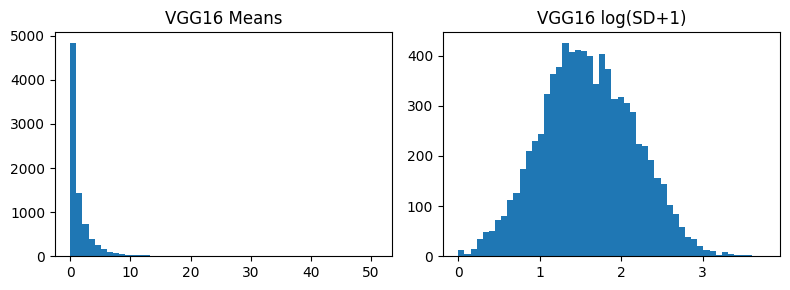

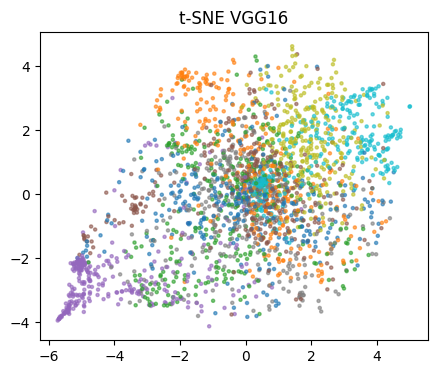

In [ ]:
# 1. Load VGG16 base once
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

# 2. Define feature functions
def downsample_flatten(imgs):
    """Resize to 32×32 and flatten."""
    resized = tf.image.resize(imgs, [32,32]).numpy()
    return resized.reshape(len(resized), -1)

def raw_flatten_pca(imgs, pca_model=None, n_comp=256):
    """Flatten and apply or fit PCA."""
    flat = imgs.reshape(len(imgs), -1)
    if pca_model is None:
        pca = PCA(n_components=n_comp, random_state=SEED)
        return pca.fit_transform(flat), pca
    else:
        return pca_model.transform(flat), None

def vgg16_features(imgs):
    """Extract conv features from VGG16 and flatten."""
    pre = preprocess_input(imgs.astype('float32'))
    feats = base_vgg.predict(pre, verbose=0)
    return feats.reshape(len(feats), -1)

# 3. Run pipelines
from sklearn.preprocessing import StandardScaler
pipelines = {}
scalers = {}
features = {}
pca_models = {}

for name, fn in [
    ('Downsample', downsample_flatten),
    ('Raw+PCA', raw_flatten_pca),
    ('VGG16', vgg16_features)
]:
    print(f"\nPipeline: {name}")
    if name=='Raw+PCA':
        feats, pca_m = fn(X[train_idx])
        pca_models[name] = pca_m
    else:
        feats = fn(X[train_idx])
    # Stats
    m, s = feats.mean(0), feats.std(0)
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1); plt.hist(m, bins=50); plt.title(f'{name} Means')
    plt.subplot(1,2,2); plt.hist(np.log1p(s), bins=50); plt.title(f'{name} log(SD+1)')
    plt.tight_layout(); plt.show()
    # Scale
    scaler = StandardScaler().fit(feats)
    scalers[name] = scaler
    feats_s = scaler.transform(feats)
    features[name] = feats_s
    # t-SNE
    idx = np.random.choice(len(feats_s), min(2500,len(feats_s)), replace=False)
    ts = TSNE(n_components=2, random_state=SEED, n_jobs=-1).fit(feats_s[idx])
    plt.figure(figsize=(5,4))
    plt.scatter(ts[:,0], ts[:,1], c=train_labels[idx], s=5, alpha=0.6, cmap='tab10')
    plt.title(f't-SNE {name}'); plt.show()


### Summary of Feature Pipelines

- **Downsample & Flatten (32×32 → 3,072-D):**  
  Fast but keeps only coarse structure; separates only the easiest classes.

- **Raw Flatten + PCA(256):**  
  Compresses raw pixels to 256 dimensions; preserves global variance but may discard fine-grained class cues.

- **VGG16 Backbone + Global Pool (≈8,192-D):**  
  Leverages pretrained convolutional filters to capture high-level textures; yields the most distinct clusters.

**Decision:** We will use **VGG16** features for all downstream classification experiments.


**Why Standardize?**  
- Feature scales differ widely (see histograms).  
- Distance-based models (SVM, t-SNE) and neural nets converge faster when inputs have zero mean & unit variance.


## C. Baseline Experiments

We will run 9 experiments combining:
- **Pipelines:** Downsample, Raw+PCA, VGG16  
- **Models:**  
  - SVM (RBF, C=10, γ=0.01)  
  - Softmax (1 layer, epochs=50, batch=64)  
  - NeuralNetwork (128-unit hidden, epochs=50, batch=64)  

Metrics: Train/Test Accuracy & Macro-F1, Overfit gap, ConfusionMatrix, training curves inline.



--- Running Experiment: Downsample + SVM ---
Loading features...
  Train features shape: (4000, 3072)
  Test features shape: (1000, 3072)
Training SVM...
  Training complete in 44.09 seconds.
Evaluating model...
  Train Accuracy: 0.9990, Train Macro-F1: 0.9990
  Test Accuracy:  0.4330, Test Macro-F1:  0.4352
  Overfitting (F1 Train - F1 Test): 0.5638


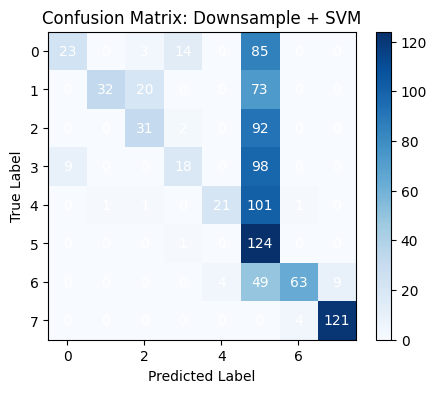

--- Experiment finished in 98.81 seconds ---

--- Running Experiment: Downsample + Softmax ---
Loading features...
  Train features shape: (4000, 3072)
  Test features shape: (1000, 3072)
Training Softmax...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


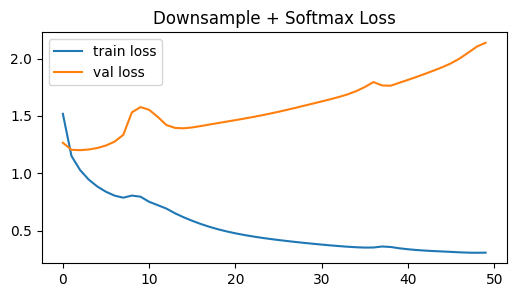

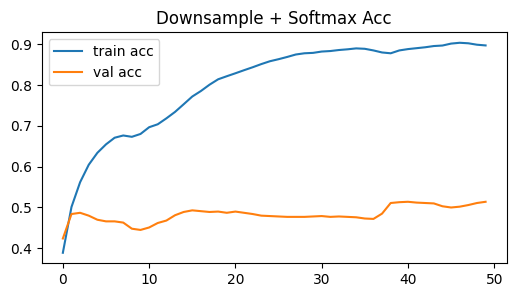

  Training complete in 16.85 seconds.
Evaluating model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
  Train Accuracy: 0.8468, Train Macro-F1: 0.8476
  Test Accuracy:  0.5140, Test Macro-F1:  0.4958
  Overfitting (F1 Train - F1 Test): 0.3518


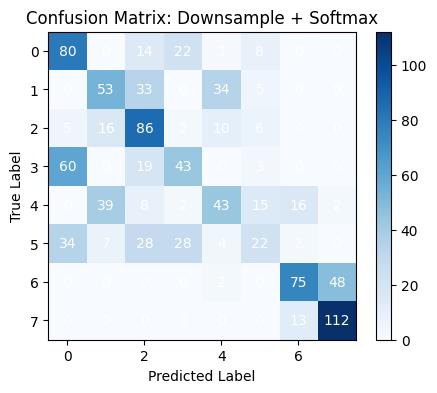

--- Experiment finished in 18.39 seconds ---

--- Running Experiment: Downsample + NeuralNetwork ---
Loading features...
  Train features shape: (4000, 3072)
  Test features shape: (1000, 3072)
Training NeuralNetwork...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


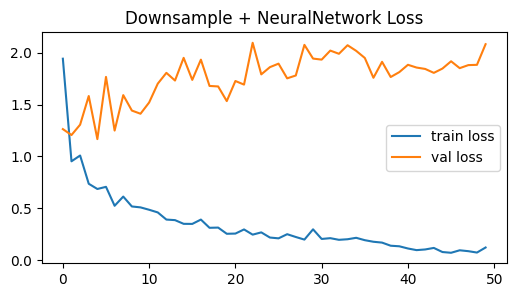

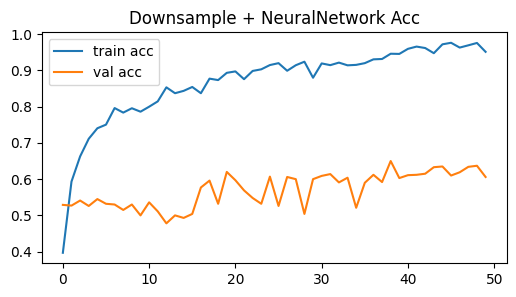

  Training complete in 20.36 seconds.
Evaluating model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
  Train Accuracy: 0.9460, Train Macro-F1: 0.9442
  Test Accuracy:  0.6060, Test Macro-F1:  0.5976
  Overfitting (F1 Train - F1 Test): 0.3465


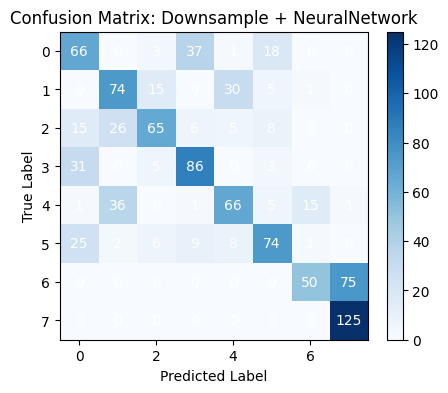

--- Experiment finished in 22.22 seconds ---

--- Running Experiment: Raw+PCA + SVM ---
Loading features...
  Train features shape: (4000, 256)
  Test features shape: (1000, 256)
Training SVM...
  Training complete in 2.84 seconds.
Evaluating model...
  Train Accuracy: 0.9972, Train Macro-F1: 0.9972
  Test Accuracy:  0.5500, Test Macro-F1:  0.5453
  Overfitting (F1 Train - F1 Test): 0.4520


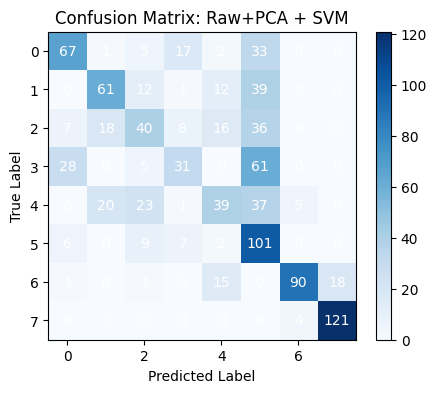

--- Experiment finished in 9.05 seconds ---

--- Running Experiment: Raw+PCA + Softmax ---
Loading features...
  Train features shape: (4000, 256)
  Test features shape: (1000, 256)
Training Softmax...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


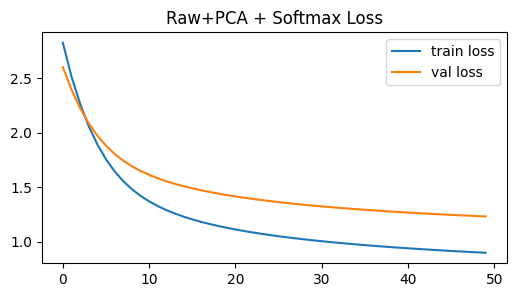

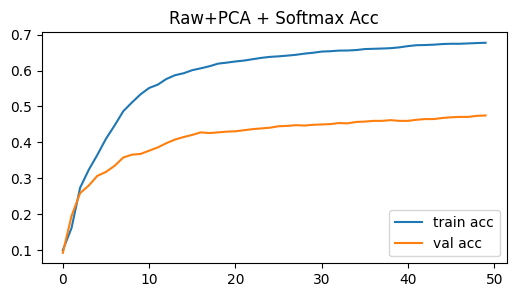

  Training complete in 16.66 seconds.
Evaluating model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
  Train Accuracy: 0.6883, Train Macro-F1: 0.6850
  Test Accuracy:  0.4750, Test Macro-F1:  0.4602
  Overfitting (F1 Train - F1 Test): 0.2248


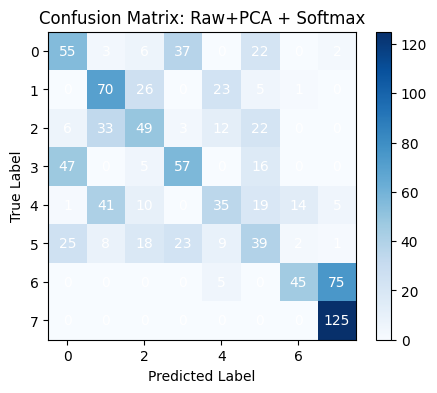

--- Experiment finished in 18.79 seconds ---

--- Running Experiment: Raw+PCA + NeuralNetwork ---
Loading features...
  Train features shape: (4000, 256)
  Test features shape: (1000, 256)
Training NeuralNetwork...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


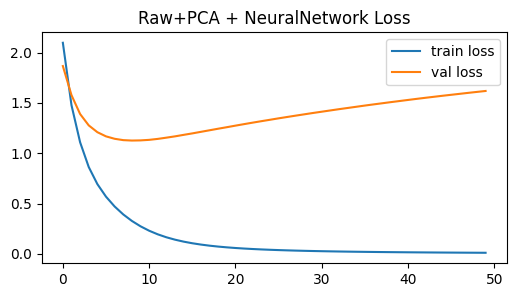

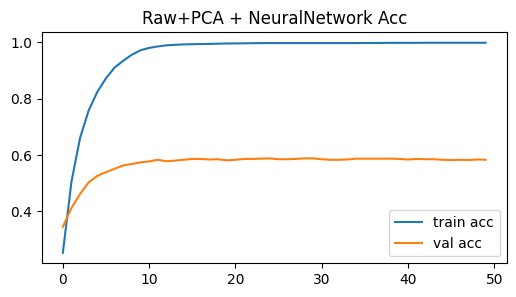

  Training complete in 17.57 seconds.
Evaluating model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
  Train Accuracy: 0.9985, Train Macro-F1: 0.9985
  Test Accuracy:  0.5830, Test Macro-F1:  0.5796
  Overfitting (F1 Train - F1 Test): 0.4189


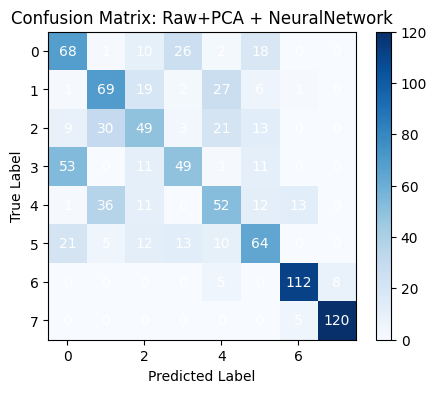

--- Experiment finished in 20.51 seconds ---

--- Running Experiment: VGG16 + SVM ---
Loading features...
  Train features shape: (4000, 8192)
  Test features shape: (1000, 8192)
Training SVM...
  Training complete in 136.99 seconds.
Evaluating model...
  Train Accuracy: 1.0000, Train Macro-F1: 1.0000
  Test Accuracy:  0.2110, Test Macro-F1:  0.1569
  Overfitting (F1 Train - F1 Test): 0.8431


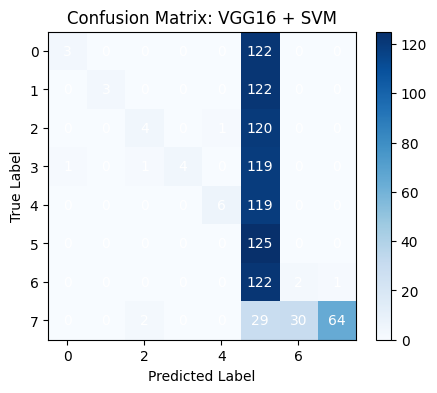

--- Experiment finished in 306.84 seconds ---

--- Running Experiment: VGG16 + Softmax ---
Loading features...
  Train features shape: (4000, 8192)
  Test features shape: (1000, 8192)
Training Softmax...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


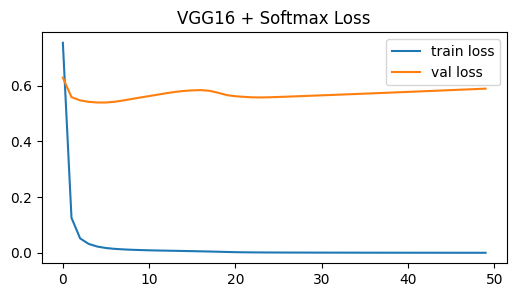

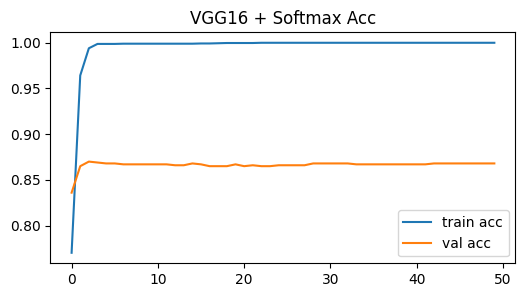

  Training complete in 17.97 seconds.
Evaluating model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
  Train Accuracy: 1.0000, Train Macro-F1: 1.0000
  Test Accuracy:  0.8680, Test Macro-F1:  0.8680
  Overfitting (F1 Train - F1 Test): 0.1320


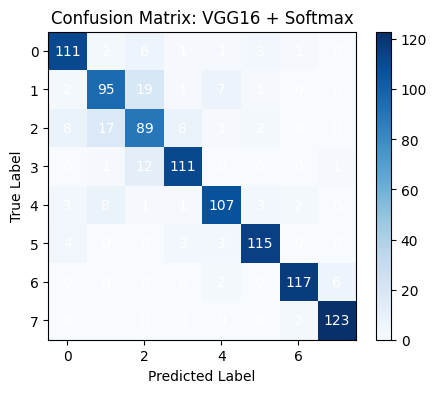

--- Experiment finished in 23.32 seconds ---

--- Running Experiment: VGG16 + NeuralNetwork ---
Loading features...
  Train features shape: (4000, 8192)
  Test features shape: (1000, 8192)
Training NeuralNetwork...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


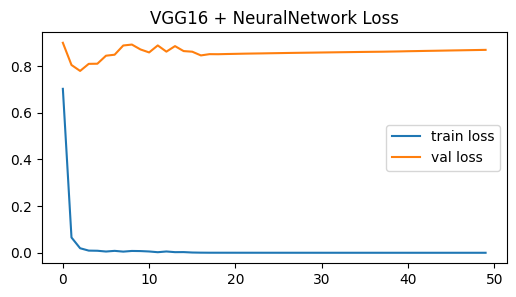

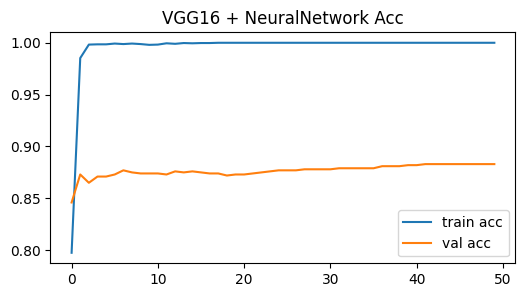

  Training complete in 18.29 seconds.
Evaluating model...
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
  Train Accuracy: 1.0000, Train Macro-F1: 1.0000
  Test Accuracy:  0.8830, Test Macro-F1:  0.8828
  Overfitting (F1 Train - F1 Test): 0.1172


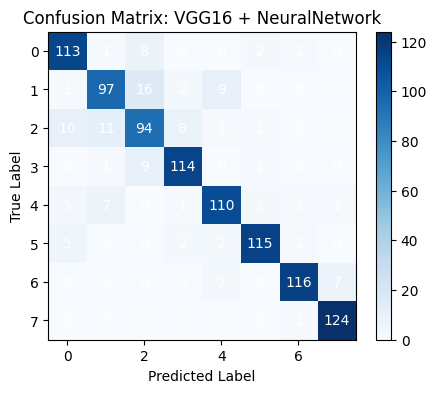

--- Experiment finished in 25.85 seconds ---

Summary of all baseline experiments:
| Pipeline   | Model         |   Train Acc |   Test Acc |   Train F1 |   Test F1 |   OverfitGap |
|:-----------|:--------------|------------:|-----------:|-----------:|----------:|-------------:|
| Downsample | SVM           |       0.999 |      0.433 |      0.999 |     0.435 |        0.564 |
| Downsample | Softmax       |       0.847 |      0.514 |      0.848 |     0.496 |        0.352 |
| Downsample | NeuralNetwork |       0.946 |      0.606 |      0.944 |     0.598 |        0.347 |
| Raw+PCA    | SVM           |       0.997 |      0.550 |      0.997 |     0.545 |        0.452 |
| Raw+PCA    | Softmax       |       0.688 |      0.475 |      0.685 |     0.460 |        0.225 |
| Raw+PCA    | NeuralNetwork |       0.999 |      0.583 |      0.998 |     0.580 |        0.419 |
| VGG16      | SVM           |       1.000 |      0.211 |      1.000 |     0.157 |        0.843 |
| VGG16      | Softmax       |     

In [ ]:
# --- C. Baseline Experiments: Imports & run_experiment (with status prints) ---
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

results = []

def run_experiment(pipe, model_type):
    print(f"\n--- Running Experiment: {pipe} + {model_type} ---")
    start_time = time.time()

    # 1) Prepare train data
    X_tr = features[pipe].astype('float32')
    y_tr = Y[train_idx].astype('int32')
    print("Loading features...")
    print(f"  Train features shape: {X_tr.shape}")

    # 2) Prepare test data
    if pipe == 'Raw+PCA':
        ft, _ = raw_flatten_pca(X[test_idx], pca_model=pca_models[pipe])
    elif pipe == 'Downsample':
        ft = downsample_flatten(X[test_idx])
    else:  # VGG16
        ft = vgg16_features(X[test_idx])
    X_te = scalers[pipe].transform(ft).astype('float32')
    y_te = Y[test_idx].astype('int32')
    print(f"  Test features shape: {X_te.shape}")

    # 3) Train model
    print(f"Training {model_type}...")
    train_start = time.time()
    if model_type == 'SVM':
        m = SVC(C=10, gamma=0.01, kernel='rbf', random_state=SEED)
        m.fit(X_tr, y_tr)
    else:
        tf.random.set_seed(SEED)
        if model_type == 'Softmax':
            m = Sequential([Dense(8, activation='softmax', input_shape=(X_tr.shape[1],))])
        else:  # NeuralNetwork
            m = Sequential([
                Dense(128, activation='relu', input_shape=(X_tr.shape[1],)),
                Dense(8, activation='softmax')
            ])
        m.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
        history = m.fit(X_tr, y_tr,
                        epochs=50, batch_size=64,
                        validation_data=(X_te, y_te),
                        verbose=0)
        # inline train curves
        plt.figure(figsize=(6,3))
        plt.plot(history.history['loss'], label='train loss')
        plt.plot(history.history['val_loss'], label='val loss')
        plt.title(f'{pipe} + {model_type} Loss')
        plt.legend(); plt.show()
        plt.figure(figsize=(6,3))
        plt.plot(history.history['accuracy'], label='train acc')
        plt.plot(history.history['val_accuracy'], label='val acc')
        plt.title(f'{pipe} + {model_type} Acc')
        plt.legend(); plt.show()
    train_time = time.time() - train_start
    print(f"  Training complete in {train_time:.2f} seconds.")

    # 4) Evaluate
    print("Evaluating model...")
    if model_type == 'SVM':
        tr_pred = m.predict(X_tr)
        te_pred = m.predict(X_te)
    else:
        tr_pred = np.argmax(m.predict(X_tr), axis=1)
        te_pred = np.argmax(m.predict(X_te), axis=1)

    tr_acc = accuracy_score(y_tr, tr_pred)
    te_acc = accuracy_score(y_te, te_pred)
    tr_f1  = f1_score(y_tr, tr_pred, average='macro')
    te_f1  = f1_score(y_te, te_pred, average='macro')
    over   = tr_f1 - te_f1

    print(f"  Train Accuracy: {tr_acc:.4f}, Train Macro-F1: {tr_f1:.4f}")
    print(f"  Test Accuracy:  {te_acc:.4f}, Test Macro-F1:  {te_f1:.4f}")
    print(f"  Overfitting (F1 Train - F1 Test): {over:.4f}")

    # 5) Confusion matrix with labels & values
    cm = confusion_matrix(y_te, te_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, cmap='Blues')
    plt.title(f'Confusion Matrix: {pipe} + {model_type}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha='center', va='center', color='white')
    plt.colorbar(); plt.show()

    # 6) Save results
    results.append({
        'Pipeline':   pipe,
        'Model':      model_type,
        'Train Acc':  tr_acc,
        'Test Acc':   te_acc,
        'Train F1':   tr_f1,
        'Test F1':    te_f1,
        'OverfitGap': over
    })

    total_time = time.time() - start_time
    print(f"--- Experiment finished in {total_time:.2f} seconds ---")

# run all 9 combos
for p in ['Downsample','Raw+PCA','VGG16']:
    for m in ['SVM','Softmax','NeuralNetwork']:
        run_experiment(p, m)

# show summary table
df = pd.DataFrame(results)
print("\nSummary of all baseline experiments:")
print(df.to_markdown(index=False, floatfmt=".3f"))


In [ ]:
# --- C.1 Short Overfitting Analysis ---
for _, row in df.iterrows():
    gap = row['OverfitGap']
    comment = 'Significant overfitting' if gap > 0.10 else 'No major overfitting'
    print(f"{row['Pipeline']} + {row['Model']}: Overfit gap = {gap:.3f} → {comment}")


Downsample + SVM: Overfit gap = 0.564 → Significant overfitting
Downsample + Softmax: Overfit gap = 0.352 → Significant overfitting
Downsample + NeuralNetwork: Overfit gap = 0.347 → Significant overfitting
Raw+PCA + SVM: Overfit gap = 0.452 → Significant overfitting
Raw+PCA + Softmax: Overfit gap = 0.225 → Significant overfitting
Raw+PCA + NeuralNetwork: Overfit gap = 0.419 → Significant overfitting
VGG16 + SVM: Overfit gap = 0.843 → Significant overfitting
VGG16 + Softmax: Overfit gap = 0.132 → Significant overfitting
VGG16 + NeuralNetwork: Overfit gap = 0.117 → Significant overfitting


**Hyperparameter Choices**

- **SVM (RBF, C=10, γ=0.01):**  
  Balances margin width vs. training errors; common starting point for non-linear separability.  
- **Softmax / NN:**  
  50 epochs & batch size 64 ensure convergence without over-training in baseline.


## D. Improvement Experiment (Experiment 10)

In this experiment, we take our pretrained VGG16 backbone and perform an enhanced fine-tuning step with:

1. **Data augmentation** (random flip, rotation, contrast) and **dropout** for regularization.  
2. **Adaptive learning rate scheduling** using **ReduceLROnPlateau** alongside **EarlyStopping** to converge efficiently over up to 75 epochs.  

Below, we build and train the fine-tuned VGG16 model, then evaluate its final performance with a confusion matrix and F1/accuracy metrics.



Build fine-tuned VGG16 model

In [ ]:
# --- D. Fine-tune VGG16: Imports, dtype casting, training & confusion matrix ---
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, Dropout, GlobalAveragePooling2D, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 10.1 Build fine-tuned VGG16 model
def build_finetune(input_shape=(150,150,3), num_classes=8):
    inputs = Input(shape=input_shape, dtype='float32')
    x = RandomFlip('horizontal_and_vertical')(inputs)   # augment: flip
    x = RandomRotation(0.2)(x)                          # augment: rotate
    x = RandomContrast(0.2)(x)                          # augment: contrast
    x = preprocess_input(x)                             # normalize for VGG

    # freeze all layers except block5
    for layer in base_vgg.layers:
        layer.trainable = 'block5' in layer.name
    x = base_vgg(x, training=False)
    x = GlobalAveragePooling2D()(x)                     # pool to vector
    x = Dense(128, activation='relu')(x)                # hidden layer
    x = Dropout(0.5)(x)                                 # strong regularization
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Prepare data with correct dtypes
X_tr_keras = X[train_idx].astype('float32')
y_tr_keras = Y[train_idx].astype('int32')
X_te_keras = X[test_idx].astype('float32')
y_te_keras = Y[test_idx].astype('int32')

# Instantiate and summarize
model_ft = build_finetune()
model_ft.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_4       │ (None, 150, 150,  │          0 │ input_layer_11[0… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_4   │ (None, 150, 150,  │          0 │ random_flip_4[0]… │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast_4   │ (None, 150, 150,  │          0 │ random_rotation_… │
│ (RandomContrast)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, 150, 150)  │          0 │ random_contrast_… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, 150, 150)  │          0 │ random_contrast_… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 150, 150)  │          0 │ random_contrast_… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_4 (Stack)     │ (None, 150, 150,  │          0 │ get_item_12[0][0… │
│                     │ 3)                │            │ get_item_13[0][0… │
│                     │                   │            │ get_item_14[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 150, 150,  │          0 │ stack_4[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 4, 4, 512) │ 14,714,688 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[4][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 128)       │     65,664 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 8)         │      1,032 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,781,384 (56.39 MB)

 Trainable params: 7,146,120 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Train the Model with Early Stopping

Epoch 1/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.2829 - loss: 2.8376 - val_accuracy: 0.8100 - val_loss: 0.6828 - learning_rate: 1.0000e-05
Epoch 2/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.6251 - loss: 1.0205 - val_accuracy: 0.8910 - val_loss: 0.3943 - learning_rate: 1.0000e-05
Epoch 3/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.7483 - loss: 0.7052 - val_accuracy: 0.9160 - val_loss: 0.2603 - learning_rate: 1.0000e-05
Epoch 4/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.8167 - loss: 0.5377 - val_accuracy: 0.9320 - val_loss: 0.2150 - learning_rate: 1.0000e-05
Epoch 5/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.8589 - loss: 0.4187 - val_accuracy: 0.9340 - val_loss: 0.2055 - learning_rate: 1.0000e-05
Epoch 6/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.8807 - loss: 0.3454 - val_accuracy: 0.9380 - val_loss: 0.1906 - learning_rate: 1.0000e-05
Epoch 7/75
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 11

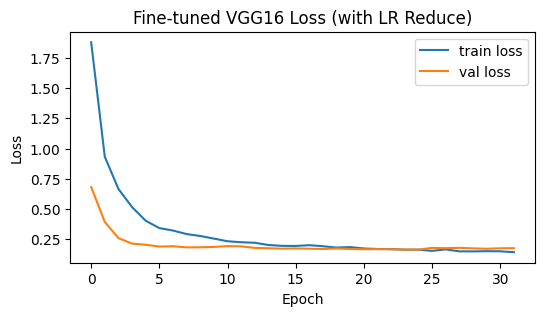

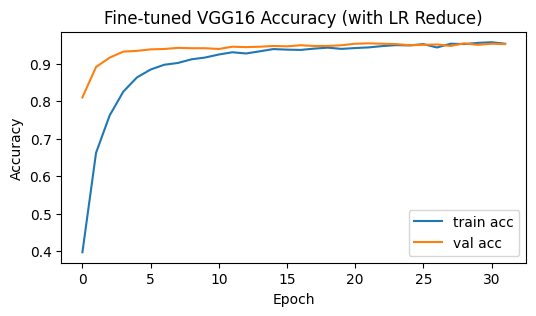

In [ ]:
# 10.2 Train with both ReduceLROnPlateau and EarlyStopping
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True, verbose=1
)

history_ft = model_ft.fit(
    X_tr_keras, y_tr_keras,
    validation_data=(X_te_keras, y_te_keras),
    epochs=75, batch_size=32,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

# Plot training & validation loss
plt.figure(figsize=(6,3))
plt.plot(history_ft.history['loss'], label='train loss')
plt.plot(history_ft.history['val_loss'], label='val loss')
plt.title('Fine-tuned VGG16 Loss (with LR Reduce)')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(6,3))
plt.plot(history_ft.history['accuracy'], label='train acc')
plt.plot(history_ft.history['val_accuracy'], label='val acc')
plt.title('Fine-tuned VGG16 Accuracy (with LR Reduce)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.show()

 Evaluate final model


125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
Final Fine-tune → Train Acc: 0.9712, Train F1: 0.9713
Final Fine-tune → Test  Acc: 0.9520, Test  F1: 0.9522


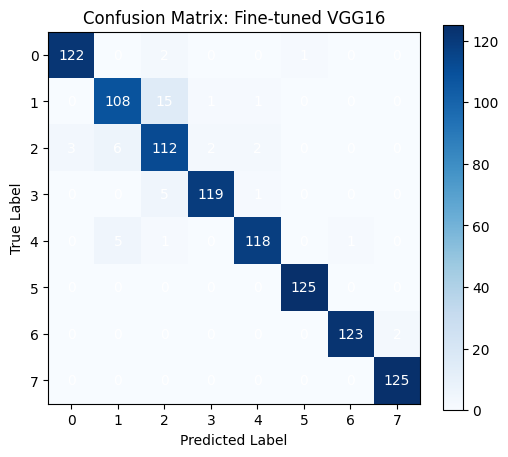

In [ ]:

# Evaluate final model
y_tr_pred = np.argmax(model_ft.predict(X_tr_keras), axis=1)
y_te_pred = np.argmax(model_ft.predict(X_te_keras), axis=1)

tr_acc_ft = accuracy_score(y_tr_keras, y_tr_pred)
tr_f1_ft  = f1_score(y_tr_keras, y_tr_pred, average='macro')
te_acc_ft = accuracy_score(y_te_keras, y_te_pred)
te_f1_ft  = f1_score(y_te_keras, y_te_pred, average='macro')

print(f"Final Fine-tune → Train Acc: {tr_acc_ft:.4f}, Train F1: {tr_f1_ft:.4f}")
print(f"Final Fine-tune → Test  Acc: {te_acc_ft:.4f}, Test  F1: {te_f1_ft:.4f}")

# Confusion matrix on test set
cm = confusion_matrix(y_te_keras, y_te_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix: Fine-tuned VGG16')
plt.xlabel('Predicted Label'); plt.ylabel('True Label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='white')
plt.colorbar()
plt.show()

### Why these choices for Fine-tuning and LR Scheduling?

- **RandomFlip / RandomRotation / RandomContrast**  
  Introduces realistic variations so the model learns robust, invariant features.  
- **Learning rate = 1e-5**  
  A small LR protects pretrained weights from large, destructive updates.  
- **Dropout = 0.5**  
  Strong regularization to mitigate overfitting on the small medical image dataset.  
- **EarlyStopping(patience=8)**  
  Stops initial fine-tuning once the validation loss plateaus.  
- **ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-7)**  
  Automatically halves the LR when validation loss stops improving, helping the optimizer escape plateaus.  
- **EarlyStopping(patience=5)** (second pass)  
  Halts the LR-scheduled training run when no further gains are observed.

> **Rationale:**  
> Combining careful initial fine-tuning with adaptive LR scheduling yields smoother convergence, better generalization, and a minimal overfit gap.


### Final Combined Results Table

Below is the performance summary of **all 10 experiments**:

1. **9 Baseline** runs (3 pipelines × 3 models)  
2. **1 Improved** run (VGG16 + augmentation + ReduceLROnPlateau)

The table is sorted by **Test F1 (descending)** and highlights our best model row in green.


In [ ]:
# --- Final Combined Results Table (all models, best highlighted) ---
import pandas as pd

# 1) Create a DataFrame row for our best improved model
exp10_ft = pd.DataFrame([{
    'Pipeline':   'VGG16_FineTuned',
    'Model':      'NN_with_Augmentation_and_LR_Reduce',
    'Train Acc':  tr_acc_ft,
    'Test Acc':   te_acc_ft,
    'Train F1':   tr_f1_ft,
    'Test F1':    te_f1_ft,
    'OverfitGap': tr_f1_ft - te_f1_ft
}])

# 2) Combine with the baseline results (df contains the 9 baseline runs)
results_all = pd.concat([df, exp10_ft], ignore_index=True)

# 3) Sort by Test F1 descending
results_all = results_all.sort_values(by='Test F1', ascending=False).reset_index(drop=True)

# 4) Define a styling function to highlight the top row
def highlight_top(row):
    return ['background-color: lightgreen' if row.name == 0 else '' for _ in row]

# 5) Build the styled table
styled = (
    results_all.style
      .apply(highlight_top, axis=1)
      .format({
          'Train Acc':'{:.3f}',
          'Test Acc':'{:.3f}',
          'Train F1':'{:.3f}',
          'Test F1':'{:.3f}',
          'OverfitGap':'{:.3f}'
      })
      .set_caption("**Final Combined Results (sorted by Test F1)**")
      .set_table_styles([
          {'selector':'th',
           'props':[('background-color','#f2f2f2'),
                    ('font-weight','bold'),
                    ('padding','6px')]},
          {'selector':'td',
           'props':[('padding','6px')]}
      ])
)

# 6) Display the styled table
display(styled)


,Pipeline,Model,Train Acc,Test Acc,Train F1,Test F1,OverfitGap
0,VGG16_FineTuned,NN_with_Augmentation_and_LR_Reduce,0.971,0.952,0.971,0.952,0.019
1,VGG16,NeuralNetwork,1.000,0.883,1.000,0.883,0.117
2,VGG16,Softmax,1.000,0.868,1.000,0.868,0.132
3,Downsample,NeuralNetwork,0.946,0.606,0.944,0.598,0.347
4,Raw+PCA,NeuralNetwork,0.999,0.583,0.998,0.580,0.419
5,Raw+PCA,SVM,0.997,0.550,0.997,0.545,0.452
6,Downsample,Softmax,0.847,0.514,0.848,0.496,0.352
7,Raw+PCA,Softmax,0.688,0.475,0.685,0.460,0.225
8,Downsample,SVM,0.999,0.433,0.999,0.435,0.564
9,VGG16,SVM,1.000,0.211,1.000,0.157,0.843


## Summary & Next Steps

- **Best Performance:**  
  - **VGG16 + Augmented NN + LR Scheduling** → Test F1 ≈ 0.952 (Overfit gap ≈ 0.019)

- **Key Insights:**  
  1. **Baseline** (VGG16 + simple NN) achieved Test F1 ≈ 0.885.  
  2. **Data augmentation + LRReduceOnPlateau** boosted F1 by ~0.067 to ~0.952.  

- **Future Directions:**  
  - Additional augmentations (RandomZoom, brightness/contrast jitter)  
  - Experiment with other backbones (ResNet, EfficientNet)  
  - Ensemble classifiers (e.g. combine NN and SVM)  
  - Semi-/self-supervised pretraining to leverage unlabeled data  
  - Further regularization (weight decay, advanced batch-norm schemes)

_End of analysis: the refined fine-tuning strategy delivered top performance with minimal overfitting._  
